In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import seaborn as sbn
sbn.set_style('dark')

In [3]:
from mvpa2.base.hdf5 import h5load
from mvpa2.datasets.mri import fmri_dataset, Dataset
from mvpa2.suite import Sphere, IndexQueryEngine
import numpy as np
from os.path import join as pjoin
from mvpa2.datasets.mri import map2nifti
import pandas as pd

In [4]:
basedir = '/data/famface/openfmri/results/l2ants_final/model001/task001/subjects_all/'
anatype_fam = 'slmskz5vx_svm/familiar_vs_unfamiliar-id'
anatype_id = 'slmskz5vx_svm/identity-familiar+identity-unfamiliar'
# using cerebmask maps
ds_fam = fmri_dataset(pjoin(basedir, 'stats/mvpa', anatype_fam, 'avg_sl_map_cerebmask_thrmap05.nii.gz'))
ds_id = fmri_dataset(pjoin(basedir, 'stats/mvpa', anatype_id, 'avg_sl_map_cerebmask_thrmap05.nii.gz'))
mask = fmri_dataset('/data/famface/openfmri/results/l2ants_final/model001/task001/subjects_all/mask/union_mask_33sbjs_80p_MNI_cerebrum.nii.gz')
mask_ = mask.samples[0] > 0
ds_fam = ds_fam[:, mask_]
ds_id = ds_id[:, mask_]

 * Please note: warnings are printed only once, but underlying problem might occur many times *


In [5]:
# load ROIs
df_roi = pd.read_csv('rois_centers.csv')
roi_names = list(df_roi['Abbreviation'])

In [6]:
rois = {row[1]: row[2:] for row in df_roi.itertuples()}

In [7]:
print("Using {0} ROIs".format(len(rois)))

Using 30 ROIs


In [8]:
invaffine = np.linalg.inv(ds_fam.a.imgaffine)
def xyz2ijk(xyz):
    xyz1 = np.hstack((xyz, [1]))
    ijk = np.dot(invaffine, xyz1)[:3].astype(int)
    return ijk

In [9]:
rois_ijk = {key: xyz2ijk(xyz) for key, xyz in rois.iteritems()}

In [10]:
def filter_voxel_indices(nbr, vxl_indices, center_coord):
    # 45 is the i coordinate for x = 0mm
    sign_center = np.sign(center_coord[0] - 45)
    sign_vxl_indices = np.sign(vxl_indices[:, 0] - 45)
    return np.asarray(nbr)[sign_center * sign_vxl_indices > 0]

In [11]:
# now make a bigger qe
qe_radius = 5
sphere = Sphere(qe_radius)
qe = IndexQueryEngine(voxel_indices=sphere)
qe.train(ds_fam)

In [12]:
rois_ = dict()
for roi, roi_coord in rois_ijk.iteritems():
    print("Querying {0}: {1}".format(roi, roi_coord))
    nbr = qe.query(voxel_indices=roi_coord)
    # filter so we keep only voxels in the same hemisphere
    nbr = filter_voxel_indices(nbr, ds_fam.fa.voxel_indices[nbr], 
                               roi_coord)
    rois_[roi] = (roi_coord, nbr)


Querying IFG1 - L: [70 83 32]
Querying EV2 - L: [47 20 33]
Querying EV1 - R: [40 16 38]
Querying mFus - R: [26 44 24]
Querying mFus - L: [62 41 27]
Querying EV1 - L: [47 20 38]
Querying EV2 - R: [43 18 31]
Querying TPJ - L: [74 34 50]
Querying mMTG - L: [77 48 32]
Querying vPreCun - L: [49 36 46]
Querying pMTG - L: [78 39 38]
Querying pMTG - R: [14 41 36]
Querying vPreCun - R: [41 36 47]
Querying mMTG - R: [15 46 35]
Querying TPJ - R: [20 36 51]
Querying pFus - L: [63 33 29]
Querying OccFus - R: [34 23 30]
Querying MPFC - L: [49 87 32]
Querying aFus - R: [25 56 22]
Querying MPFC - R: [38 85 42]
Querying OccFus - L: [61 23 29]
Querying pFus - R: [31 27 29]
Querying mPreCun - R: [43 30 52]
Querying dPreCun - L: [48 30 61]
Querying aMTG - L: [74 63 24]
Querying IFG2 - R: [22 76 35]
Querying aMTG - R: [14 56 30]
Querying IFG2 - L: [64 86 37]
Querying dPreCun - R: [42 31 61]
Querying mPreCun - L: [50 35 53]


In [13]:
for roi, (center, ids) in rois_.iteritems():
    print("{0} ({2}): {1}".format(roi, len(ids), center))

IFG1 - L ([70 83 32]): 349
EV2 - L ([47 20 33]): 361
EV1 - R ([40 16 38]): 477
mFus - R ([26 44 24]): 299
mFus - L ([62 41 27]): 409
EV1 - L ([47 20 38]): 344
EV2 - R ([43 18 31]): 275
TPJ - L ([74 34 50]): 463
mMTG - L ([77 48 32]): 392
vPreCun - L ([49 36 46]): 405
pMTG - L ([78 39 38]): 337
pMTG - R ([14 41 36]): 502
vPreCun - R ([41 36 47]): 470
mMTG - R ([15 46 35]): 515
TPJ - R ([20 36 51]): 515
pFus - L ([63 33 29]): 443
OccFus - R ([34 23 30]): 436
MPFC - L ([49 87 32]): 485
aFus - R ([25 56 22]): 459
MPFC - R ([38 85 42]): 498
OccFus - L ([61 23 29]): 474
pFus - R ([31 27 29]): 378
mPreCun - R ([43 30 52]): 367
dPreCun - L ([48 30 61]): 436
aMTG - L ([74 63 24]): 376
IFG2 - R ([22 76 35]): 515
aMTG - R ([14 56 30]): 467
IFG2 - L ([64 86 37]): 515
dPreCun - R ([42 31 61]): 436
mPreCun - L ([50 35 53]): 514


In [14]:
def plot_overlapping_voxels(rois):
    """
    rois is assumed to be a dict with values a tuple with (center_ids, list of voxel indices):
    """
    # sort labels
    roi_names = sorted(sorted(rois), key=lambda x: x.split()[-1])
    nroi_names = len(roi_names)
    overlapping_voxels = np.zeros((nroi_names, nroi_names))
    for irow, roi_name_row in enumerate(roi_names):
        for icol, roi_name_col in enumerate(roi_names):
            if icol == irow:
                n_overlapping = len(rois[roi_name_row][1])
            else:
                n_overlapping = len(set(rois[roi_name_row][1]).intersection(rois[roi_name_col][1]))
            overlapping_voxels[irow, icol] = n_overlapping
    
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111)
    sbn.heatmap(overlapping_voxels.astype(int), annot=True, fmt="d", linewidths=.5,
               xticklabels=roi_names, yticklabels=roi_names)
    
    return fig, overlapping_voxels

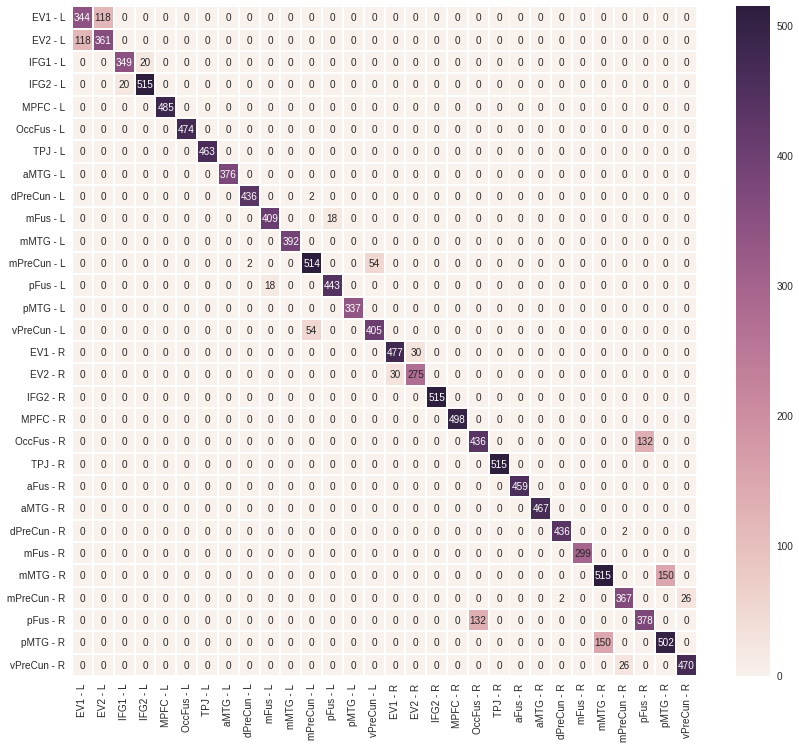

In [15]:
fig, overlapping_voxels = plot_overlapping_voxels(rois_)

In [16]:
from collections import defaultdict

def reassign_overlapping_voxels(rois, template_ds):
    # we want to reassing the overlapping voxels to the closest node
    # first have a mapping from center node to the label
    center2label = {tuple(value[0]): key for key, value in rois.iteritems()}

    # make a hashtable that maps each node to the center of the searchlight it belongs to
    voxelindex2center = defaultdict(list)
    for key, (center, voxel_indices) in rois.iteritems():
        for voxel_index in voxel_indices:
            voxelindex2center[voxel_index].append(center)

    # now assign to the closest node
    def dist(x, y):
        return np.sum((x - y)**2)

    # loop through all of them and assign them to the closest node
    for voxel, centers in voxelindex2center.iteritems():
        if len(centers) == 1:  # we're good
            continue
        voxel_idx = template_ds.fa.voxel_indices[voxel]
        dist_centers = [dist(voxel_idx, center) for center in centers]
        # reassing the minimum
        voxelindex2center[voxel] = [centers[np.argmin(dist_centers)]]

    # now map back to the common dictionary
    rois_nooverlap = defaultdict(list)
    for voxel, center in voxelindex2center.iteritems():
        # look up label
        lbl = center2label[tuple(center[0])]
        rois_nooverlap[lbl].append(voxel)
        
    # return a dictionary similar to the original one, i.e. with
    # values being a tuple (center_voxel, [indices])
    for label, voxel_indices in rois_nooverlap.iteritems():
        rois_nooverlap[label] = (rois[label][0], sorted(voxel_indices))
    
    return rois_nooverlap

In [17]:
rois_no_overlap = reassign_overlapping_voxels(rois_, template_ds=ds_fam)

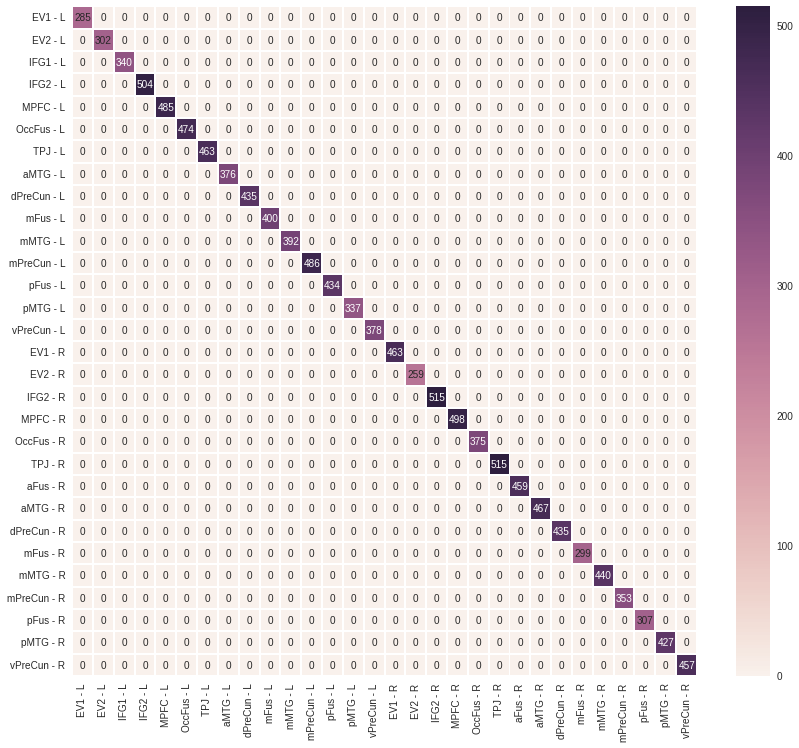

In [18]:
fig_no_overlap, overlapping_voxels_no_overlap = plot_overlapping_voxels(rois_no_overlap)

In [19]:
avg_voxels = np.diag(overlapping_voxels_no_overlap).mean()
std_voxels = np.diag(overlapping_voxels_no_overlap).std()
print('Average number of voxels: {0:.0f} ({1:.0f})'.format(avg_voxels, std_voxels))

Average number of voxels: 412 (73)


## Save ROIs


In [20]:
#from mvpa2.base.hdf5 import h5save
#h5save('manual_rois_20170222_5r_no-overlap.hdf5', dict(rois_no_overlap))

## Map it back to a volume

In [21]:
ds_template = fmri_dataset('/usr/share/data/fsl-mni152-templates/MNI152_T1_2mm_brain.nii.gz')

In [22]:
ds_template = ds_template[:, mask_]

In [23]:
# make one single dataset with all the labels overlapping
ds_labels = np.zeros((1, ds_fam.nfeatures), dtype=int)
for i, roi_name in enumerate(roi_names):
    roi_ids = rois_no_overlap[roi_name][1]
    ds_labels[0, roi_ids] = i + 1

ds_labels_ = Dataset(ds_labels, a=ds_template.a)
#map2nifti(ds_labels_).to_filename('rois_manual_r{0}_20170222_nooverlap.nii.gz'.format(qe_radius))

In [24]:
# now map ROIs to systems
early_visual = 1
ventral_core_system = 2
dorsal_core_system = 3
anterior_core_system = 4
precuneus = 5
theory_of_mind = 6

label2nr = {
'EV1 - L': early_visual,
'EV1 - R': early_visual,
'EV2 - L': early_visual,
'EV2 - R': early_visual,
'IFG1 - L': anterior_core_system,
'IFG2 - L': anterior_core_system,
'IFG2 - R': anterior_core_system,
'MPFC - L': theory_of_mind,
'MPFC - R': theory_of_mind,
'OccFus - L': ventral_core_system,
'OccFus - R': ventral_core_system,
'TPJ - L': theory_of_mind,
'TPJ - R': theory_of_mind,
'aFus - R': ventral_core_system,
'aMTG - L': dorsal_core_system,
'aMTG - R': dorsal_core_system,
'dPreCun - L': precuneus,
'dPreCun - R': precuneus,
'mFus - L': ventral_core_system,
'mFus - R': ventral_core_system,
'mMTG - L': dorsal_core_system,
'mMTG - R': dorsal_core_system,
'mPreCun - L': precuneus,
'mPreCun - R': precuneus,
'pFus - L': ventral_core_system,
'pFus - R': ventral_core_system,
'pMTG - L': dorsal_core_system,
'pMTG - R': dorsal_core_system,
'vPreCun - L': precuneus,
'vPreCun - R': precuneus,
}

In [25]:
ds_labels = np.zeros((1, ds_fam.nfeatures), dtype=int)
for i, roi_name in enumerate(roi_names):
    roi_ids = rois_no_overlap[roi_name][1]
    ds_labels[0, roi_ids] = label2nr[roi_name]

ds_labels_ = Dataset(ds_labels, a=ds_template.a)
#map2nifti(ds_labels_).to_filename('rois_manual_r{0}_20170222_nooverlap_systems.nii.gz'.format(qe_radius))

In [26]:
for i, roi_name in enumerate(roi_names):
    print('{0:02d}: {1}'.format(i+1, roi_name))

01: EV1 - L
02: EV1 - R
03: EV2 - L
04: EV2 - R
05: OccFus - L
06: OccFus - R
07: pFus - L
08: pFus - R
09: mFus - L
10: mFus - R
11: pMTG - L
12: pMTG - R
13: aFus - R
14: mMTG - L
15: mMTG - R
16: aMTG - L
17: aMTG - R
18: IFG1 - L
19: IFG2 - L
20: IFG2 - R
21: TPJ - L
22: TPJ - R
23: MPFC - L
24: MPFC - R
25: dPreCun - L
26: dPreCun - R
27: mPreCun - L
28: mPreCun - R
29: vPreCun - L
30: vPreCun - R


# Do the same in 3 mm for Raiders

In [27]:
# load template in 3mm
# this is for Raiders
mask_fn = '/home/swaroop/mvpa_linux_bkup/slhyper/MNI/MNI_mask_cerebrum.nii.gz'
cerebrum_mask = fmri_dataset(mask_fn, mask=mask_fn)

In [28]:
# need to go from ijk to xyz
affine = cerebrum_mask.a.imgaffine
def ijk2xyz(ijk):
    ijk1 = np.hstack((ijk, [1]))
    xyz = np.dot(affine, ijk1)[:3].astype(int)
    return xyz

In [29]:
# use matrix algebra to compute distances in one shot
voxel_indices = np.hstack((cerebrum_mask.fa.voxel_indices, 
                           np.ones((cerebrum_mask.nfeatures, 1))))

# xyz coordinates of each voxel in 3mm MNI space
xyz_all = np.dot(affine, voxel_indices.T)[:3].T

In [30]:
xyz_all[:10]

array([[-69., -36.,  -6.],
       [-69., -36.,  -3.],
       [-69., -36.,   0.],
       [-69., -36.,   3.],
       [-69., -33.,  -3.],
       [-69., -33.,   3.],
       [-69., -30.,  -6.],
       [-69., -30.,  -3.],
       [-69., -30.,   0.],
       [-69., -30.,   6.]])

In [31]:
from scipy.spatial.distance import cdist

In [32]:
# get the coordinates of the centers
coords_xyz = []
for row in df_roi.itertuples():
    coords_xyz.append(map(int, row[2:]))

In [33]:
# and the labels
roi_labels_ordered = list(df_roi['Abbreviation'])

In [34]:
# now for each node center find the closest voxel value
distance_from_center = cdist(coords_xyz, xyz_all)
# get argmin
argmin_distance = np.argmin(distance_from_center, axis=1)
min_distance = np.min(distance_from_center, axis=1)

In [35]:
print("Median displacement is {0:.2f}mm, min {1:.2f}mm, max {2:.2f}mm".format(
    np.median(min_distance), min_distance.min(), min_distance.max()))

Median displacement is 1.41mm, min 1.00mm, max 1.73mm


In [36]:
# now get voxel indices for the new centers
center_idx_3mm = cerebrum_mask.fa.voxel_indices[argmin_distance]

In [37]:
def filter_voxel_indices(nbr, vxl_indices, center_coord):
    # since we have computed the xyz coordinates let's use those
    xyz_center_coord = ijk2xyz(center_coord)
    sign_center = np.sign(xyz_center_coord[0])
    # get xyz coordinates
    vxl_indices_1 = np.hstack((vxl_indices, np.ones((len(vxl_indices), 1))))
    xyz_vxl_indices = np.dot(affine, vxl_indices_1.T).T
    sign_vxl_indices = np.sign(xyz_vxl_indices)[:, 0]
    return np.asarray(nbr)[sign_center * sign_vxl_indices > 0]

In [38]:
# now make a slightly smaller radius -- before it was 10mm, now it will be 9mm
qe_radius_3mm = 3
sphere_3mm = Sphere(qe_radius_3mm)
qe_3mm = IndexQueryEngine(voxel_indices=sphere_3mm)
qe_3mm.train(cerebrum_mask)

In [39]:
rois_ijk_3mm = {lbl: xyz for lbl, xyz in zip(roi_labels_ordered, center_idx_3mm)}

In [40]:
rois_3mm = dict()
for roi, roi_coord in rois_ijk_3mm.iteritems():
    print("Querying {0}: {1}".format(roi, roi_coord))
    nbr = qe_3mm.query(voxel_indices=roi_coord)
    # filter so we keep only voxels in the same hemisphere
    nbr = filter_voxel_indices(nbr, cerebrum_mask.fa.voxel_indices[nbr], 
                               roi_coord)
    rois_3mm[roi] = (roi_coord, nbr)


Querying IFG1 - L: [13 55 21]
Querying EV2 - L: [29 13 22]
Querying EV1 - R: [33 11 25]
Querying mFus - R: [43 29 16]
Querying mFus - L: [19 27 18]
Querying EV1 - L: [29 13 25]
Querying EV2 - R: [31 12 21]
Querying TPJ - L: [11 23 33]
Querying mMTG - L: [ 9 32 21]
Querying vPreCun - L: [27 24 31]
Querying pMTG - L: [ 8 26 25]
Querying pMTG - R: [51 27 24]
Querying vPreCun - R: [33 24 31]
Querying mMTG - R: [50 31 23]
Querying TPJ - R: [47 24 34]
Querying pFus - L: [18 22 19]
Querying OccFus - R: [37 15 20]
Querying MPFC - L: [27 58 21]
Querying aFus - R: [43 37 15]
Querying MPFC - R: [35 57 28]
Querying OccFus - L: [19 15 19]
Querying pFus - R: [39 18 19]
Querying mPreCun - R: [31 20 35]
Querying dPreCun - L: [28 20 41]
Querying aMTG - L: [11 42 16]
Querying IFG2 - R: [45 51 23]
Querying aMTG - R: [51 37 20]
Querying IFG2 - L: [17 57 25]
Querying dPreCun - R: [32 21 41]
Querying mPreCun - L: [27 23 35]


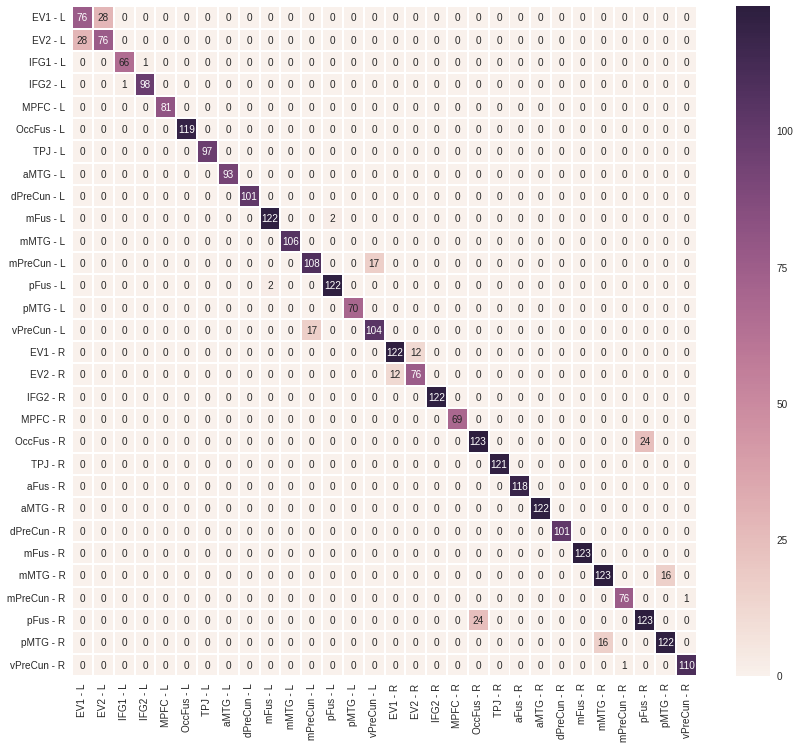

In [41]:
fig_3mm, overlapping_voxels_3mm = plot_overlapping_voxels(rois_3mm)

In [42]:
rois_3mm_no_overlap = reassign_overlapping_voxels(rois_3mm, template_ds=cerebrum_mask)

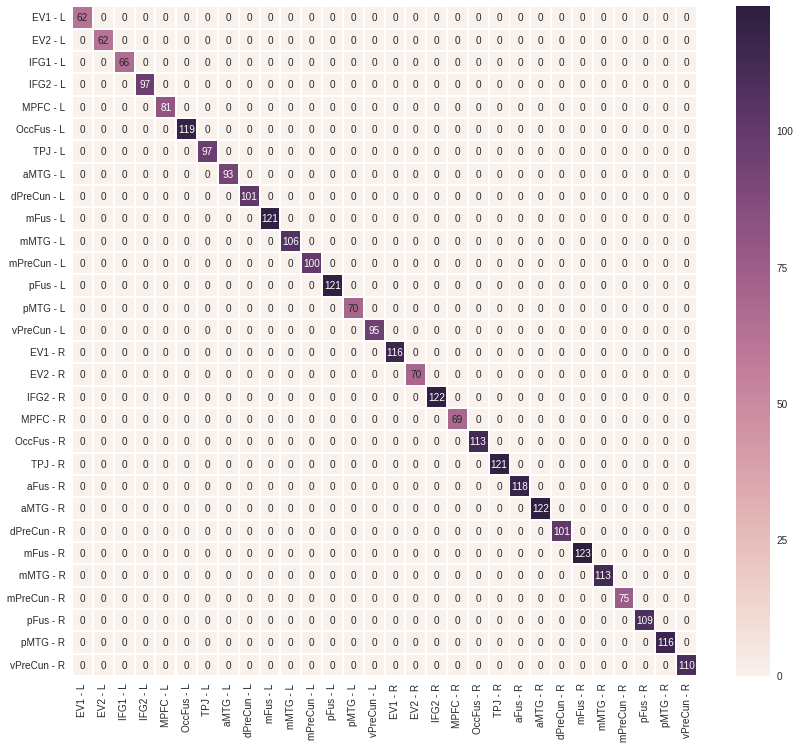

In [43]:
fig_3mm_no_overlap, overlapping_voxels_3mm_no_overlap = plot_overlapping_voxels(rois_3mm_no_overlap)

In [44]:
avg_voxels_3mm = np.diag(overlapping_voxels_3mm_no_overlap).mean()
std_voxels_3mm = np.diag(overlapping_voxels_3mm_no_overlap).std()
print('Average number of voxels: {0:.0f} ({1:.0f})'.format(avg_voxels_3mm, std_voxels_3mm))

Average number of voxels: 100 (20)


In [45]:
ds_template = cerebrum_mask

In [46]:
# make one single dataset with all the labels overlapping
ds_labels = np.zeros((1, ds_template.nfeatures), dtype=int)
for i, roi_name in enumerate(roi_names):
    roi_ids = rois_3mm_no_overlap[roi_name][1]
    ds_labels[0, roi_ids] = i + 1

In [47]:
ds_labels_ = Dataset(ds_labels, a=ds_template.a)

In [48]:
#map2nifti(ds_labels_).to_filename('rois_manual_r{0}_20170414_nooverlap_MNI3mm_mask.nii.gz'.format(qe_radius_3mm))

## Save ROIs 3mm


In [49]:
from mvpa2.base.hdf5 import h5save
#h5save('manual_rois_20170414_3r_no-overlap_MNI3mm_mask.hdf5', dict(rois_3mm_no_overlap))